In [33]:
import torch as tn
import torchtt as tntt
import TTCME
import matplotlib.pyplot as plt 
import datetime
import numpy as np
import pickle 

tn.set_default_tensor_type(tn.DoubleTensor)
qtt = True

Define the model. The 4 reaction coefficients are the parameters.

In [34]:
r1m = TTCME.ChemicalReaction(['mRNA','protein'],'mRNA->', 'c1', params = ['c1'])
r2m = TTCME.ChemicalReaction(['mRNA','protein'],'mRNA->mRNA+protein', 'c2', params = ['c2'])
r3m = TTCME.ChemicalReaction(['mRNA','protein'],'->mRNA', 'c3', params = ['c3'])
r4m = TTCME.ChemicalReaction(['mRNA','protein'],'protein->', 'c4', params = ['c4'])

mdl = TTCME.ReactionSystem(['mRNA','protein'],[r1m, r2m, r3m, r4m], params= ['c1','c2','c3','c4'])



rates = np.array([0.002,0.015,0.1,0.01])
IC = [2,4]
N = [64,64]

True model (without parameters)

In [35]:
r1 = TTCME.ChemicalReaction(['mRNA','protein'],'mRNA->',rates[0])
r2 = TTCME.ChemicalReaction(['mRNA','protein'],'mRNA->mRNA+protein', rates[1])
r3 = TTCME.ChemicalReaction(['mRNA','protein'],'->mRNA', rates[2])
r4 = TTCME.ChemicalReaction(['mRNA','protein'],'protein->', rates[3])

mdl_true = TTCME.ReactionSystem(['mRNA','protein'],[r1, r2, r3, r4])

Load the measurements and the reference from the file.

In [36]:
T = 20

np.random.seed(78923589)

reaction_time,reaction_jumps,reaction_indices = mdl_true.ssa_single(IC,T)

time_observation = reaction_time[:-1]
observations = reaction_jumps[:-1,:]
No = len(time_observation)

Plot the observations and the true trajectory.

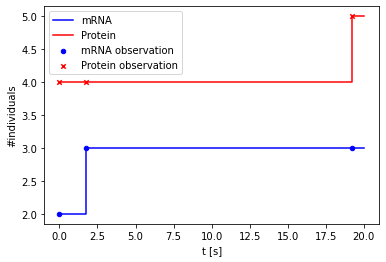

In [37]:
plt.figure()
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,0],2)[:-1],'b')
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,1],2)[:-1],'r') 
plt.scatter(time_observation,observations[:,0],c='b',s=20)
plt.scatter(time_observation,observations[:,1],c='r',marker='x',s=20)
plt.xlabel('t [s]')
plt.ylabel('#individuals')
plt.legend(['mRNA','Protein','mRNA observation','Protein observation'])

Define the basis of the parameter space.

In [38]:
Nl = 64
mult = 6
param_range = [[0,rc*mult] for rc in rates]
basis_param = [TTCME.basis.BSplineBasis(Nl,[p[0],p[1]],deg = 2) for p in param_range]

Define the prior distribution (independent gamma).

In [39]:
mu = rates
var = rates / np.array([1000,350,25,600])
alpha_prior = mu**2/var
beta_prior = mu/var
prior = TTCME.GammaPDF(alpha_prior, beta_prior, basis_param, ['c1','c2','c3','c4'])


Define the initial condition and the joint PDF.

In [40]:
p_ic = TTCME.pdf.SingularPMF(N,IC,['mRNA','protein'])
p0 = p_ic ** prior
p0.normalize()

p = p0.dofs.clone()

print(p0)

Probability density function:
p(mRNA,protein,c1,c2,c3,c4)

Basis:
Dirac-deltas basis defined on {0, 63} and dimension 64
Dirac-deltas basis defined on {0, 63} and dimension 64
B-spline basis defined on [0, 0.012] and dimension 64
B-spline basis defined on [0, 0.09] and dimension 64
B-spline basis defined on [0, 0.6000000000000001] and dimension 64
B-spline basis defined on [0, 0.06] and dimension 64

DoF:
TT with sizes and ranks:
N = [64, 64, 64, 64, 64, 64]
R = [1, 1, 1, 1, 1, 1, 1]

Device: cpu, dtype: torch.float64
#entries 384 compression 5.587935447692871e-09



Instantiate the observation operator.

Compute the CME operator for the parameter dependent case.

In [41]:
Stt,Mtt,Mtt_inv = mdl.generator_tt_galerkin(N, basis_param)
Att = Mtt_inv @ Stt

Instantiate the TT time-domain solver. If the `qtt` flag is `True`, the result will be performed in the QTT format.

In [42]:
if qtt:
    A_qtt = Att.to_qtt()
    fwd_int = TTCME.TimeIntegrator.TTInt(A_qtt, epsilon = 1e-5, N_max = 8, dt_max = 100.0,method='cheby')
    Nbs = 6
    p = p.to_qtt()
else:
    fwd_int = TTCME.TimeIntegrator.TTInt(Att, epsilon = 1e-5, N_max = 64, dt_max = 1.0,method='crank–nicolson')
    Nbs = 1

Perform the perameter inference.

In [43]:
posterior_list  =[]
joint_pdf = p0.copy()
for i in range(1,No):
    
    dT = time_observation[i]-time_observation[i-1]
    y = observations[i,:]

    
    po = TTCME.pdf.SingularPMF(N, y).dofs
    #po = po / po.sum()
    
    po = po ** tntt.ones([Nl]*4)

    if qtt: po = po.to_qtt()
    
    print('new observation ',i,'/',No,' at time ',time_observation[i],' ',y)
    
    tme = datetime.datetime.now()
    p = fwd_int.solve(p, dT, intervals = Nbs,qtt = qtt,verb = False, rounding=True)
    tme = datetime.datetime.now() - tme
    
    
    print('\tmax rank ',max(p.R))
    p_pred = p
    p_post = po * p_pred
    p_post = p_post.round(1e-10)
    print('\tmax rank (after observation) ',max(p_post.R))
    
    if qtt:
        joint_pdf.dofs = tntt.reshape(p_post,joint_pdf.dofs.N)
        Z = joint_pdf.Z
        joint_pdf.normalize()
        p = p_post / Z
    else:
        joint_pdf.dofs = p_post.clone()
        joint_pdf.normalize()
        p = joint_pdf.dofs.clone()

    
    posterior_pdf = joint_pdf.marginal([0,1])
    posterior_pdf.round(1e-10)
    posterior_list.append(posterior_pdf.copy())



    E = posterior_pdf.expected_value()
    
    print('\tExpected value computed posterior ' ,E)
    # print('\tVariance computed posterior       ' ,V)
    print('\tposterior size ',tntt.numel(p)*8 / 1000000,' MB')
    print('\telapsed ',tme)

new observation  1 / 3  at time  1.7649970663919794   [3 4]
	max rank  44
	max rank (after observation)  44
	Expected value computed posterior  [tensor(0.0020), tensor(0.0148), tensor(0.1308), tensor(0.0099)]
	posterior size  0.1564  MB
	elapsed  0:00:10.912744
new observation  2 / 3  at time  19.213419338814766   [3 5]
	max rank  179
	max rank (after observation)  170
	Expected value computed posterior  [tensor(0.0020), tensor(0.0161), tensor(0.0828), tensor(0.0092)]
	posterior size  1.843824  MB
	elapsed  0:00:29.209842


If everything is observed without noise, the posterior has a closed form

In [44]:
def CompleteObservations(sample,time,indices,props,Cs,alpha_prior=1.0,beta_prior=0.0):
    
    nr = Cs.size
    n = time.size
    T = time.max()
    
    N = np.array([np.sum(indices==j) for j in range(nr)])
       
    # print(N)
    
    G = N*0
    
    for j in range(nr):
        for k in range(1,n-1):
            G[j] += props[j](sample[k-1,:]) * (time[k]-time[k-1])
        G[j] += props[j](sample[-1,:]) * (T - time[n-1])
    
    alpha_posterior = alpha_prior + N
    beta_posterior = beta_prior + G
    
    return alpha_posterior, beta_posterior 


alpha_post, beta_post = CompleteObservations(reaction_jumps, reaction_time, reaction_indices, [lambda x: x[0], lambda x: x[0], lambda x: 1.0, lambda x: x[1]], rates, alpha_prior, beta_prior)
posterior_reference = TTCME.GammaPDF(alpha_post, beta_post, basis_param, ['c1','c2','c3','c4'])

Rank posterior TT                  [1, 64, 69, 16, 1]

Exact rates:                       [0.002 0.015 0.1   0.01 ]

Expected value computed posterior  [tensor(0.0020), tensor(0.0161), tensor(0.0828), tensor(0.0092)]
Variance computed posterior        [2.06212266e-06 4.13774511e-05 1.95421812e-03 1.40462974e-05]

Expected posterior                 [0.00189573 0.0154321  0.08139535 0.00887574]
Variance posterior                 [1.79690483e-06 3.81039476e-05 1.89291509e-03 1.31297924e-05]

Relative absolute error exp        [7.32135784 4.17489915 1.69344226 3.46855919]  %
Relative absolute error var        [12.86139908  7.91132239  3.13695929  6.52488668]  %

Expected value prior               [0.002 0.015 0.1   0.01 ]
Variance computed prior            [2.00000000e-06 4.28571429e-05 4.00000000e-03 1.66666667e-05]



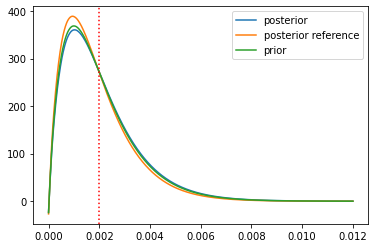

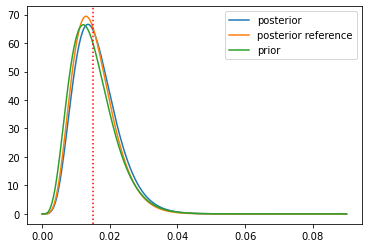

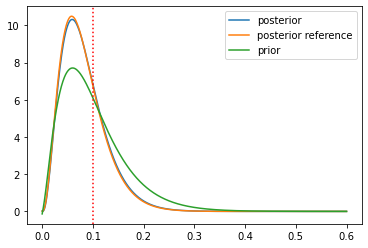

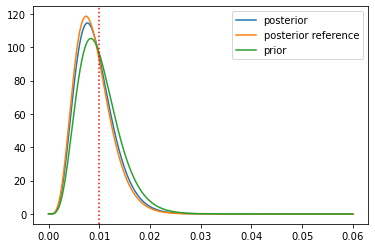

In [45]:
posterior_pdf.normalize()
nburn = 200000

E = posterior_pdf.expected_value()
C = posterior_pdf.covariance_matrix()
V = np.diag(C)

print('Rank posterior TT                 ', posterior_pdf.dofs.R)
print()
print('Exact rates:                      ',rates)
print('')
print('Expected value computed posterior ' ,E)
print('Variance computed posterior       ' ,V)
# print('Computed modes:                   ',theta_mode)
print('')
print('Expected posterior                ' , alpha_post/beta_post)
print('Variance posterior                ' , alpha_post/beta_post/beta_post)
print('')
print('Relative absolute error exp       ',np.abs(alpha_post/beta_post-E)/E * 100,' %')
print('Relative absolute error var       ',np.abs(alpha_post/beta_post/beta_post-V)/V * 100,' %')
print('')
print('Expected value prior              ' ,alpha_prior/beta_prior)
print('Variance computed prior           ' ,alpha_prior/beta_prior/beta_prior)
print('')


post_1 = posterior_pdf.marginal([1,2,3])
post_2 = posterior_pdf.marginal([0,2,3])
post_3 = posterior_pdf.marginal([0,1,3])
post_4 = posterior_pdf.marginal([0,1,2])


for i in range(4):
    pr = prior.marginal([j for j in range(4) if i!=j])
    po = posterior_pdf.marginal([j for j in range(4) if i!=j])
    por = posterior_reference.marginal([j for j in range(4) if i!=j])

    x = np.linspace(param_range[i][0],param_range[i][1],1000)
    
    
    plt.figure()
    plt.plot(x, po[x].numpy())
    plt.plot(x, por[x].numpy())
    plt.plot(x, pr[x].numpy())
    plt.axvline(rates[i],c='r',linestyle=':')
    plt.legend(['posterior','posterior reference','prior'])

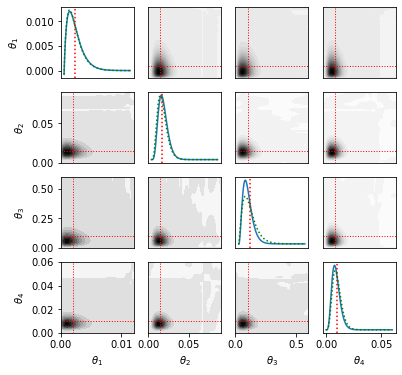

In [46]:
plt.figure(figsize = [6,6])

k = 0
for i in range(4):
    for j in range(4):
        k += 1
        if i==j:
            plt.subplot(4, 4, k)
            
            theta = np.linspace(param_range[i][0],param_range[i][1],1000)
            pr = prior.marginal([k for k in range(4) if i!=k])[theta].numpy()
            po = posterior_pdf.marginal([k for k in range(4) if i!=k])[theta].numpy()
           
            plt.plot(theta,po/np.max(po)*np.max(theta))
            # count, bins = np.histogram(sample_posterior_mcmc[nburn:,i],bins=128,density=True)
            # count = count/np.max(po)*np.max(theta)
            # plt.hist(bins[:-1], bins, weights=count,color='c',alpha=0.4)
            plt.axvline(rates[i],c='r',linestyle=':')
            plt.plot(theta,pr/np.max(po)*np.max(theta),'g:')
            
        else:
            plt.subplot(4, 4, k)
             
            if j<i: 
                theta1 = np.linspace(param_range[j][0],param_range[j][1],127)
                theta2 = np.linspace(param_range[i][0],param_range[i][1],128)
                
                T1, T2 = np.meshgrid(theta1, theta2)
                po = posterior_pdf.marginal([k for k in range(4) if i!=k and j!=k])
                po.normalize()
                po = po[theta1,theta2].numpy().T
                

                # counts,ybins,xbins,image = plt.hist2d(sample_posterior_mcmc[nburn:,j],sample_posterior_mcmc[nburn:,i],bins=100,density = True, range =[[T1.min(), T1.max()],[T2.min(), T2.max()]])
                # plt.contour(counts.T,extent=[T1.min(), T1.max(), T2.min(), T2.max()],linewidths=1,levels=10, cmap =plt.cm.Greens)

                plt.contourf(T1, T2, po, cmap='gray_r', levels =12)

                plt.axvline(rates[j],c='r',linestyle=':',linewidth=1)
                plt.axhline(rates[i],c='r',linestyle=':',linewidth=1)
            else: 
                theta1 = np.linspace(param_range[i][0],param_range[i][1],127)
                theta2 = np.linspace(param_range[j][0],param_range[j][1],128)
                
                T1, T2 = np.meshgrid(theta1, theta2)
                po = posterior_pdf.marginal([k for k in range(4) if i!=k and j!=k])
                po.normalize()
                po = po[theta1,theta2].numpy().T

                # counts,ybins,xbins,image = plt.hist2d(sample_posterior_mcmc[nburn:,j],sample_posterior_mcmc[nburn:,i],bins=100,density = True, range =[[T2.min(), T2.max()],[T1.min(), T1.max()]])
                # plt.contour(counts.T,extent=[T2.min(), T2.max(), T1.min(), T1.max()],linewidths=1,levels=10, cmap =plt.cm.Greens)

                plt.contourf(T2, T1, po, cmap='gray_r', levels =32)

                plt.axvline(rates[j],c='r',linestyle=':',linewidth=1)
                plt.axhline(rates[i],c='r',linestyle=':',linewidth=1)
        
        if i==3: plt.xlabel(r'$\theta_'+str(j+1)+'$')
        if j==0: plt.ylabel(r'$\theta_'+str(i+1)+'$')
        
        if j>0: plt.yticks([])
        if i<3: plt.xticks([])

plt.savefig('simple_gene_post.eps')